In [33]:
!pip install pycocotools
! pip install -U ffmpeg

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import cv2
from PIL import Image
import seaborn as sns
import copy
import albumentations as A

import torch
from torch.utils.data import Dataset,DataLoader,Subset
import torch.optim as optim
import torchvision
from torchvision.models.detection.ssd import SSDHead,det_utils
from torchvision.models.detection import ssd300_vgg16,SSD300_VGG16_Weights
import torchvision.transforms.functional as tf

import pycocotools
import torchmetrics
from torchmetrics.detection import MeanAveragePrecision


In [35]:
np.random.seed(42)
torch.manual_seed(42)

In [36]:
img_dir="C:/Users/surya/OneDrive/Desktop/archive(4)/images"
annot_dir="C:/Users/surya/OneDrive/Desktop/archive(4)/annotations"

#label 0 is fixed for background
classes=["background","pothole"]

num_classes=2
#device="cuda" if torch.cuda.is_available() else "cpu"
batch_size=4
epochs=40
learning_rate=3e-5

model_weights_file="model.pth"

threshold=0.25
iou_threshold=0.75

In [37]:
def parse_xml(annot_path):
    tree=ET.parse(annot_path)
    root=tree.getroot()
    
    width=int(root.find("size").find("width").text)
    height=int(root.find("size").find("height").text)
    boxes=[]
    
    for obj in root.findall("object"):
        bbox=obj.find("bndbox")
        xmin=int(bbox.find("xmin").text)
        ymin=int(bbox.find("ymin").text)
        xmax=int(bbox.find("xmax").text)
        ymax=int(bbox.find("ymax").text)
        
        boxes.append([xmin,ymin,xmax,ymax])
        
    return boxes,height,width

In [38]:
ignore_img=[]
for annot_name in os.listdir(annot_dir):
    img_name=annot_name[:-4]+".png"
    annot_path=os.path.join(annot_dir,annot_name)
    boxes,height,width=parse_xml(annot_path)
    
    for box in boxes:
        if box[0]<0 or box[0]>=box[2] or box[2]>width:
            print(box[0],box[2],width)
            print("x",annot_name)
            print("*"*50)
            ignore_img.append(img_name)
        elif box[1]<0 or box[1]>=box[3] or box[3]>height:
            print(box[1],box[3],height)
            print("y",file_name)
            print("*"*50)
            ignore_img.append(img_name)

312 401 400
x potholes214.xml
**************************************************
273 273 400
x potholes58.xml
**************************************************


In [39]:
ignore_img

['potholes214.png', 'potholes58.png']

In [40]:
train_transform=A.Compose([A.HorizontalFlip(),
                           A.ShiftScaleRotate(rotate_limit=15,value=0,
                                              border_mode=cv2.BORDER_CONSTANT),

                           A.OneOf(
                                   [A.CLAHE(),
                                    A.RandomBrightnessContrast(),
                                    A.HueSaturationValue()],p=1),
                           A.GaussNoise(),
                           A.RandomResizedCrop(height=480,width=480)],
                          bbox_params=A.BboxParams(format="pascal_voc",min_visibility=0.15,
                                                   label_fields=["labels"]))
                           
val_transform=A.Compose([A.Resize(height=480,width=480)],
                        bbox_params=A.BboxParams(format="pascal_voc",min_visibility=0.15,
                                                 label_fields=["labels"]))

In [41]:
class PotholeDetection(Dataset):
    def __init__(self,img_dir,annot_dir,transform=None):
        super().__init__()
        self.img_dir=img_dir
        self.annot_dir=annot_dir
        self.img_list=sorted([img for img in os.listdir(self.img_dir) 
                              if img not in ignore_img])
        self.transform=transform
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,idx):
        img_name=self.img_list[idx]
        img_path=os.path.join(self.img_dir,img_name)
        img=cv2.imread(img_path)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        annot_name=img_name[:-4]+".xml"
        annot_path=os.path.join(self.annot_dir,annot_name)
        boxes,height,width=parse_xml(annot_path)
        labels=[1]*len(boxes)
        
        if self.transform is not None:
            transformed=self.transform(image=img,bboxes=boxes,labels=labels)
            img=transformed["image"]
            boxes=transformed["bboxes"]
            labels=transformed["labels"]
        
        if len(np.array(boxes).shape)!=2 or np.array(boxes).shape[-1]!=4:
            boxes=[[0.0,0.0,1.0,1.0]]
            labels=[0]
                
        img=img/255
        img=tf.to_tensor(img)
        img=img.to(dtype=torch.float32)
        target={}
        target["boxes"]=torch.tensor(boxes,dtype=torch.float32)
        target["labels"]=torch.tensor(labels,dtype=torch.int64)
        target["id"]=torch.tensor(idx)
            
        return img,target

In [42]:
train_ds=PotholeDetection(img_dir,annot_dir,train_transform)
val_ds=PotholeDetection(img_dir,annot_dir,val_transform)

In [43]:
from torch.utils.data import Subset

In [44]:
idxs=list(range(len(train_ds)))

np.random.shuffle(idxs)
train_idx=idxs[:int(0.85*len(train_ds))]
val_idx=idxs[int(0.85*len(train_ds)):]

train_ds=Subset(train_ds,train_idx)
val_ds=Subset(val_ds,val_idx)

In [45]:
len(val_ds)

100

In [46]:
def show_bbox(img,target,color=(0,255,0)):
    img=np.transpose(img.cpu().numpy(),(1,2,0))
    boxes=target["boxes"].cpu().numpy().astype("int")
    labels=target["labels"].cpu().numpy()
    img=img.copy()
    for i,box in enumerate(boxes):
        idx=int(labels[i])
        text=classes[idx]

        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,text,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
        
    return img

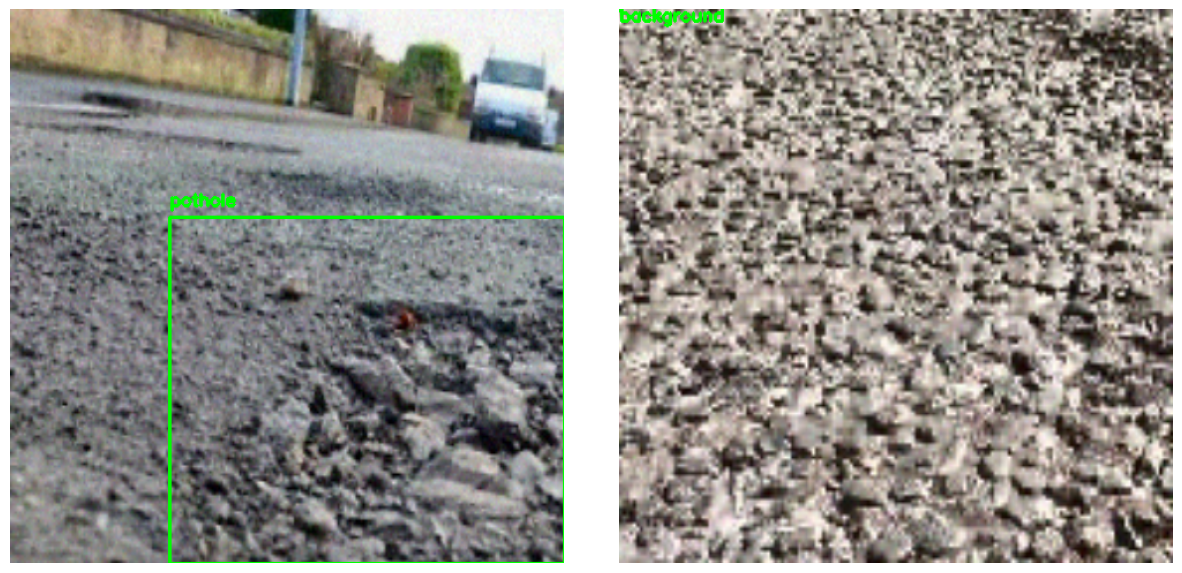

In [47]:
fig,axes=plt.subplots(1,2,figsize=(15,24))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

idxs=np.random.choice(range(len(train_ds)),2)
for i,idx in enumerate(idxs):
    img,target=train_ds[idx]
    output_img=show_bbox(img,target)
    ax[i].imshow(output_img)
    ax[i].axis("off")